In [ ]:
# Testing Portfolio Optimization Strategies

In [1]:
from datetime import datetime
start_date = '2005-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

/tmp/ipykernel_512561/4222555550.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  6 of 6 completed


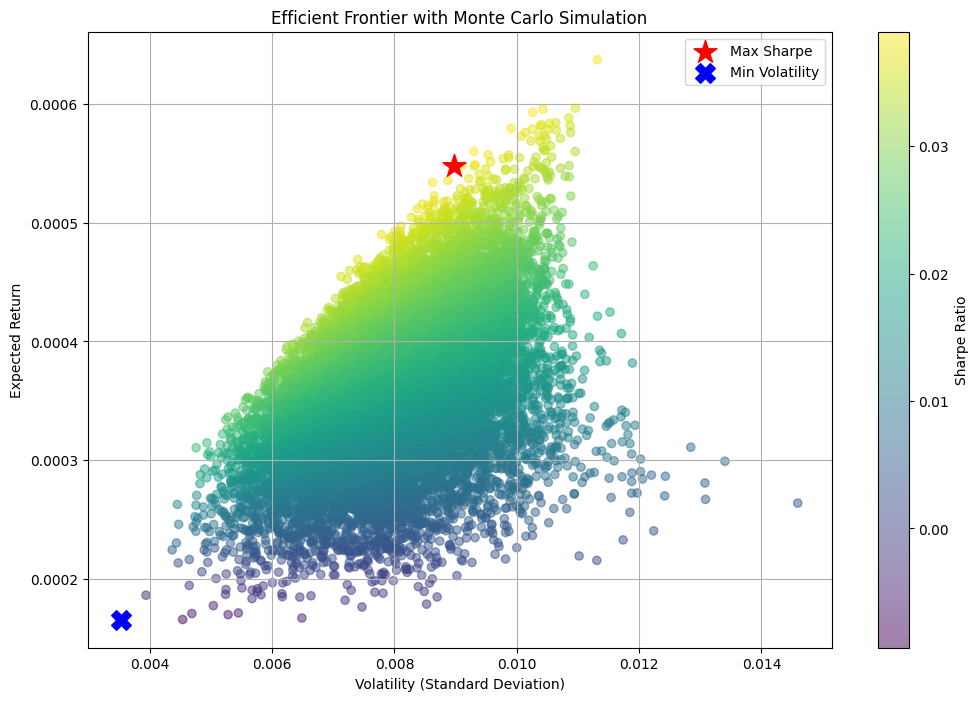

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Load data
tickers = ['SPY', 'VXUS', 'QQQ', 'GLD', 'SLV', 'SHY']
data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

# Step 2: Compute returns stats
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)
risk_free_rate = 0.05 / 252

# Step 3: Simulate random portfolios
num_portfolios = 20000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = sharpe_ratio

# Step 4: Find optimal portfolios
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[1])

max_sharpe_weights = weights_record[max_sharpe_idx]
min_vol_weights = weights_record[min_vol_idx]

# Step 5: Plot efficient frontier
plt.figure(figsize=(12, 8))
scatter = plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.scatter(results[1,max_sharpe_idx], results[0,max_sharpe_idx], marker='*', color='r', s=300, label='Max Sharpe')
plt.scatter(results[1,min_vol_idx], results[0,min_vol_idx], marker='X', color='b', s=200, label='Min Volatility')

plt.title('Efficient Frontier with Monte Carlo Simulation')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
def print_portfolio(weights, label):
    print(f"\n{label}")
    for ticker, weight in zip(tickers, weights):
        print(f"{ticker}: {weight:.2%}")
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / std
    print(f"Return: {ret:.2%}, Risk: {std:.2%}, Sharpe: {sharpe:.2f}")

print_portfolio(max_sharpe_weights, "Max Sharpe Portfolio")
print_portfolio(min_vol_weights, "Min Volatility Portfolio")



Max Sharpe Portfolio
SPY: 21.92%
VXUS: 38.84%
QQQ: 5.44%
GLD: 1.41%
SLV: 32.30%
SHY: 0.08%
Return: 0.05%, Risk: 0.90%, Sharpe: 0.04

Min Volatility Portfolio
SPY: 14.02%
VXUS: 0.59%
QQQ: 58.88%
GLD: 2.95%
SLV: 7.17%
SHY: 16.39%
Return: 0.02%, Risk: 0.35%, Sharpe: -0.01


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data
data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)

# Target risk level (annualized)
target_risk = 0.25  # adjust to taste
target_risk_daily = target_risk / np.sqrt(252)  # convert to daily std

# Portfolio performance functions
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Objective: maximize return (minimize negative return)
def negative_return(weights, mean_returns):
    return -portfolio_return(weights, mean_returns)

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # sum to 1
    {'type': 'eq', 'fun': lambda w: portfolio_volatility(w, cov_matrix) - target_risk_daily}  # match target risk
]

# Bounds (no shorting)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess
initial_weights = np.ones(num_assets) / num_assets

# Optimization
result = minimize(negative_return,
                  initial_weights,
                  args=(mean_returns,),
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

optimal_weights = result.x
expected_return = portfolio_return(optimal_weights, mean_returns) * 252  # annualized
expected_risk = portfolio_volatility(optimal_weights, cov_matrix) * np.sqrt(252)

# Print results
print("🎯 Optimal Portfolio (Max Return for Target Risk):")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")
print(f"\nExpected Annual Return: {expected_return:.2%}")
print(f"Expected Annual Risk:   {expected_risk:.2%}")


/tmp/ipykernel_512561/2493859277.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  6 of 6 completed


🎯 Optimal Portfolio (Max Return for Target Risk):
SPY: 1.02%
VXUS: 4.64%
QQQ: 1.98%
GLD: 84.36%
SLV: 4.20%
SHY: 3.80%

Expected Annual Return: 6.74%
Expected Annual Risk:   25.00%


[*********************100%***********************]  6 of 6 completed


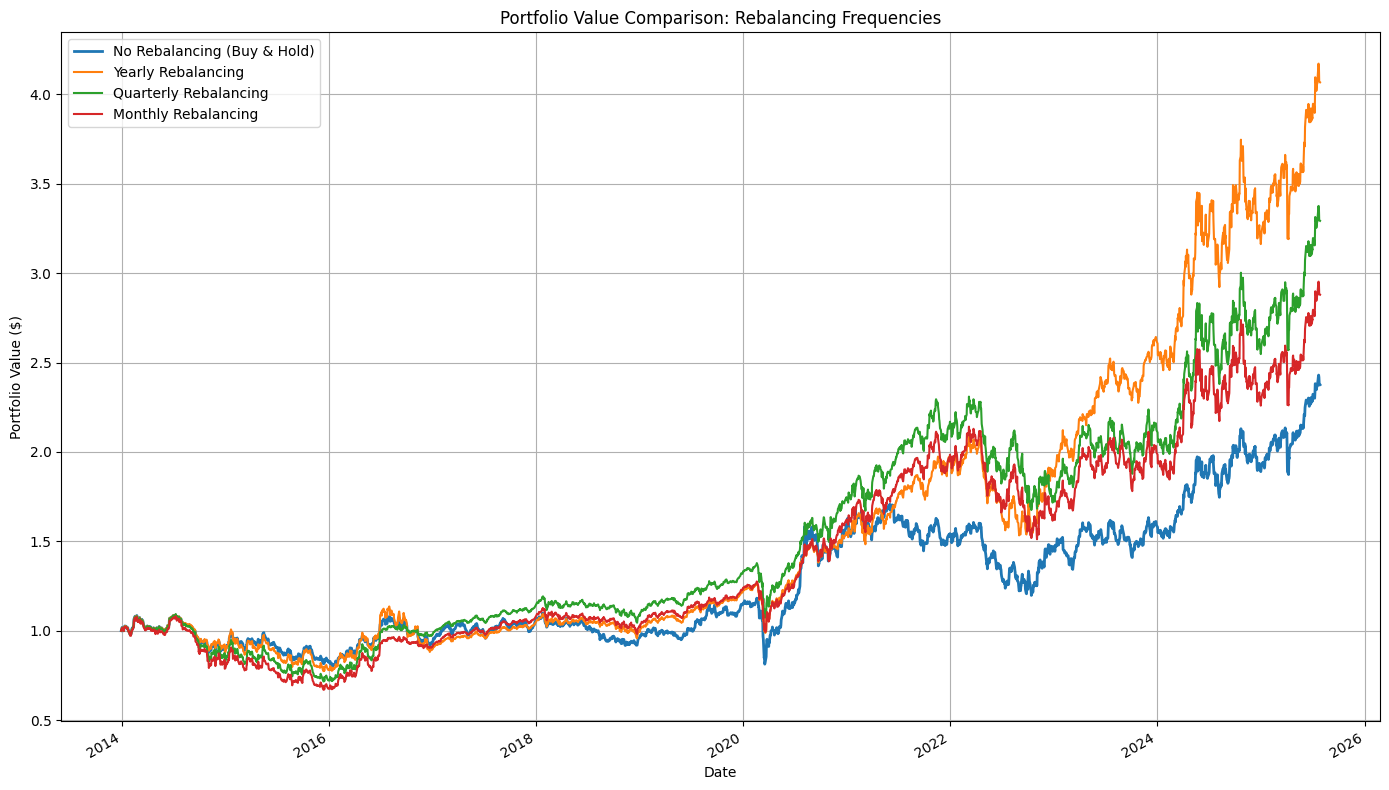

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime

# Download historical price data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
returns = data.pct_change().dropna()

# Portfolio parameters
lookback_years = 3
target_risk = 0.25  # annualized
target_risk_daily = target_risk / np.sqrt(252)
num_assets = len(tickers)

def get_optimal_weights(lookback_returns):
    mean_ret = lookback_returns.mean()
    cov_mat = lookback_returns.cov()

    def portfolio_vol(w):
        return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

    def negative_return(w):
        return -np.dot(w, mean_ret)

    cons = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_vol(w) - target_risk_daily}
    ]
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(negative_return, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x if result.success else init_guess

def simulate_portfolio(rebalance_freq):
    rebalance_dates = returns.resample(rebalance_freq).first().index
    current_value = 1.0
    portfolio_values = []

    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else returns.index[-1]

        lookback_start = start_date - pd.DateOffset(years=lookback_years)
        lookback_returns = returns.loc[lookback_start:start_date]

        if len(lookback_returns) < 252 * lookback_years * 0.8:
            continue

        future_returns = returns.loc[start_date:end_date]
        if future_returns.empty:
            continue

        weights = get_optimal_weights(lookback_returns)
        port_ret = future_returns @ weights
        cumulative = (1 + port_ret).cumprod() * current_value

        if cumulative.empty:
            continue

        portfolio_values.append(cumulative)
        current_value = cumulative.iloc[-1]

    if portfolio_values:
        full_series = pd.concat(portfolio_values)
        full_series.index = pd.to_datetime(full_series.index)
        return full_series
    else:
        return pd.Series(dtype=float)

# === Buy and Hold: one-time optimization ===
initial_weights = get_optimal_weights(returns.iloc[:252 * lookback_years])
buy_hold_returns = returns @ initial_weights
buy_hold_cumulative = (1 + buy_hold_returns).cumprod()

# === Rebalanced Portfolios ===
rebal_yearly = simulate_portfolio('YE')
rebal_quarterly = simulate_portfolio('QE')
rebal_monthly = simulate_portfolio('ME')

# === Align start dates ===
min_start_date = max(
    buy_hold_cumulative.index[0],
    rebal_yearly.index[0],
    rebal_quarterly.index[0],
    rebal_monthly.index[0],
)

buy_hold_cumulative = buy_hold_cumulative[buy_hold_cumulative.index >= min_start_date]
rebal_yearly = rebal_yearly[rebal_yearly.index >= min_start_date]
rebal_quarterly = rebal_quarterly[rebal_quarterly.index >= min_start_date]
rebal_monthly = rebal_monthly[rebal_monthly.index >= min_start_date]

# === Normalize all series to $1 ===
def normalize(series):
    return series / series.iloc[0]

buy_hold_cumulative = normalize(buy_hold_cumulative)
rebal_yearly = normalize(rebal_yearly)
rebal_quarterly = normalize(rebal_quarterly)
rebal_monthly = normalize(rebal_monthly)

# === Plot ===
plt.figure(figsize=(14, 8))
buy_hold_cumulative.plot(label='No Rebalancing (Buy & Hold)', linewidth=2)
rebal_yearly.plot(label='Yearly Rebalancing', linewidth=1.5)
rebal_quarterly.plot(label='Quarterly Rebalancing', linewidth=1.5)
rebal_monthly.plot(label='Monthly Rebalancing', linewidth=1.5)

plt.title("Portfolio Value Comparison: Rebalancing Frequencies")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




